# Graph Analysis

This notebook analyzes the recommendation graph. Emphasis on assortativity.

In [1]:
import os
import pandas
import json
import numpy as np
import pandas as pd

import networkx as nx
from matplotlib import pyplot as plt

### Data Import and Preparation

In [3]:
# import the graph from adjacency list
G = nx.read_adjlist(create_using=nx.DiGraph(), 
                    path="../../data/derived_data/analysis_redo/adjacency_list.txt")

# wrap in features
with open('../../data/scrape_results_redo/video_info.json', 'r') as f:
    video_info = json.load(f)

In [4]:
# make a category_name <-> id mapping for easier category handling
category_df = pd.read_csv('../../data/derived_data/category_crosswalk.csv')
category_list = category_df.category_id.values

categories = set(category_list)
cat_mapping = {}
for ix, category_id in enumerate(categories):
    cat_mapping[category_id] = ix

In [8]:
# Create node attributes by filling dictionaries with video_id and info
category = {}
views = {}
lr = {}
postdate = {}
channel = {}
for video_id in video_info:
    info = video_info.get(video_id, {})
    try:
        like_ratio = int(info['likes']) / (int(info['likes']) + int(info['dislikes']))
    except ZeroDivisionError:
        like_ratio = 0.5
    
    channel[video_id] = info['channel']
    category[video_id] = cat_mapping[int(info['category'])]
    views[video_id] = int(info['views'])
    lr[video_id] = float(like_ratio)
    postdate[video_id] =  info['postdate']
    
# do the same for channel/video bias
channel_classification = pd.read_csv('../../data/derived_data/analysis_redo/channel_classification.csv')
video_info_df = pd.DataFrame.from_dict(video_info, orient='index').reset_index()
video_info_df.rename(index=str, columns={"index": "video_id"}, inplace=True)
video_info_df = video_info_df[['video_id', 'channel']]
video_info_df['channel'] = video_info_df.channel.apply(str.lower)
video_info_df = video_info_df.merge(channel_classification, on='channel', how='left')\
                .dropna(axis=0, subset=['leaning'])
bias_dict = video_info_df[['video_id', 'leaning']].set_index('video_id').to_dict(orient='index')

# make dictionary of bias
bias = {}
for video_id in bias_dict:
    bias[video_id] = bias_dict[video_id]['leaning']
    
nx.set_node_attributes(G, name='leaning', values=bias)
nx.set_node_attributes(G, name='category', values=category)
nx.set_node_attributes(G, name='views', values=views)
nx.set_node_attributes(G, name='like_ratio', values=lr)
nx.set_node_attributes(G, name='postdate', values=postdate)
nx.set_node_attributes(G, name='channel', values=channel)

### Assortativity

In [9]:
# assortativity
print(nx.attribute_assortativity_coefficient(G, 'category'))
print(nx.attribute_assortativity_coefficient(G, 'channel'))
print(nx.attribute_assortativity_coefficient(G, 'leaning'))
#print(nx.numeric_assortativity_coefficient(G, attribute='views'))
#print(nx.numeric_assortativity_coefficient(G, attribute='like_ratio'))

0.6212606432182186
0.5314986471220333
0.7483356709878127


In [10]:
# mix_matrix[i,j] = count of i -> j edges
mix_matrix = nx.attribute_mixing_matrix(G, 
                                        attribute='leaning',
                                        mapping={'L': 0, 'C': 1, 'R': 2},
                                        normalized=False)

# normalize so rows sum to 1; choosing rows so that each cell can
# be interpreted as the frequency with which category i recommends a video
# in category j (row sums are the out-degree)
mix_matrix = mix_matrix / mix_matrix.sum(axis=1, keepdims=True)

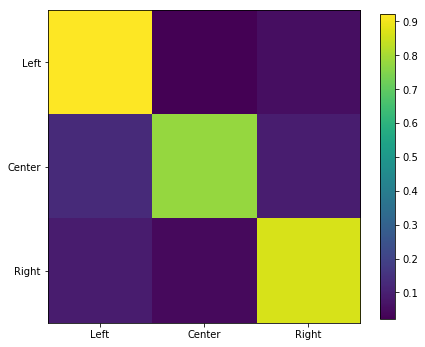

In [13]:
plt.figure(figsize=(7,7))
plt.imshow(mix_matrix)
plt.colorbar(shrink=0.8)
plt.xticks(np.arange(3), ('Left', 'Center', 'Right'))
plt.yticks(np.arange(3), ('Left', 'Center', 'Right'))
plt.show()
#plt.savefig('presentation_resources/leaning_mixing_matrix', dpi=300)